In [1]:
import himalaya.scoring
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV, GroupRidgeCV

from simulation import generate_dataset

In [2]:
set_backend('cupy', on_error='warn')
backend = get_backend()
plt.style.use('nord')
sns.set_theme(style='whitegrid')

In [3]:
d_list = [100, 100, 100]
scalars = [1 / 3, 1 / 3, 1 / 3]
n_targets = 10000
n_samples_train = 1000
n_samples_test = 100
noise_scalar = 0.1

In [4]:
alphas = np.logspace(-4, 4, 10)
cv = 10
score_func = himalaya.scoring.r2_score

In [5]:
(Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(d_list, scalars, n_targets, n_samples_train, n_samples_test,
                                                        noise_scalar, construction_method="random")

train joint model

In [6]:
banded_solver_params = dict(n_iter=10, alphas=alphas, progress_bar=False, warn=False, score_func=score_func,
                            n_targets_batch=1000)
joint_model = GroupRidgeCV(groups="input", solver_params=banded_solver_params)

In [7]:
joint_model.fit(Xs_train, Y_train)
Y_pred = joint_model.predict(Xs_test)
joint_score = score_func(Y_test, Y_pred)
joint_score = backend.to_numpy(joint_score)

<Axes: ylabel='Count'>

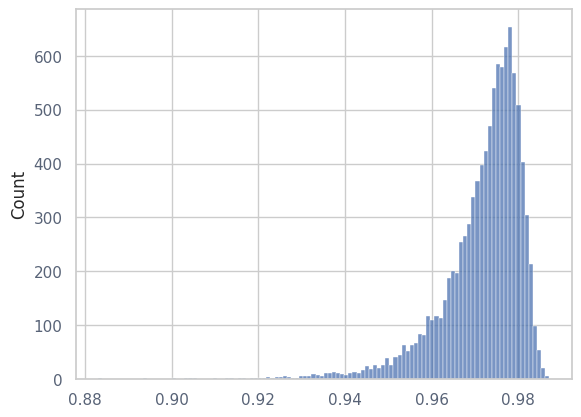

In [8]:
sns.histplot(joint_score)

train single models

In [9]:
solver_params = dict(warn=False, score_func=score_func, n_targets_batch=1000)
single_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)

Fit and predict for i = 0

In [10]:
single_model.fit(Xs_train[0], Y_train)
score_0 = single_model.score(Xs_test[0], Y_test)
score_0 = backend.to_numpy(score_0)

<Axes: ylabel='Count'>

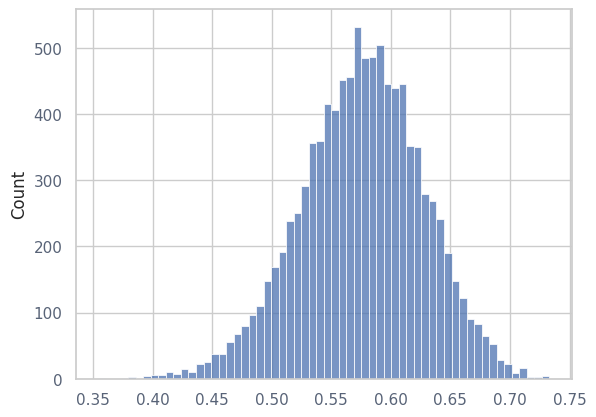

In [11]:
sns.histplot(score_0)

Fit and predict for i = 1

In [12]:
single_model.fit(Xs_train[1], Y_train)
score_1 = single_model.score(Xs_test[1], Y_test)
score_1 = backend.to_numpy(score_1)

<Axes: ylabel='Count'>

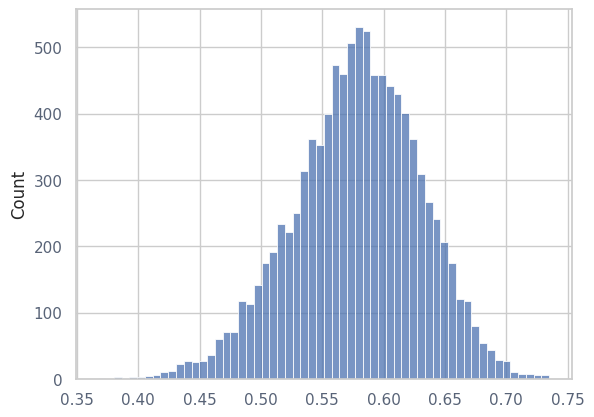

In [13]:
sns.histplot(score_1)

Calculate unique and shared variance

In [14]:
shared = (score_0 + score_1) - joint_score
x0_unique = score_0 - shared
x1_unique = score_1 - shared

In [15]:
shared = backend.to_numpy(shared)
x0_unique = backend.to_numpy(x0_unique)
x1_unique = backend.to_numpy(x1_unique)

create pandas dataset of all scores for analysis

In [16]:
scores = pd.DataFrame({
    "joint": joint_score,
    "x0": score_0,
    "x1": score_1,
    "x0_unique": x0_unique,
    "x1_unique": x1_unique,
    "shared": shared
})

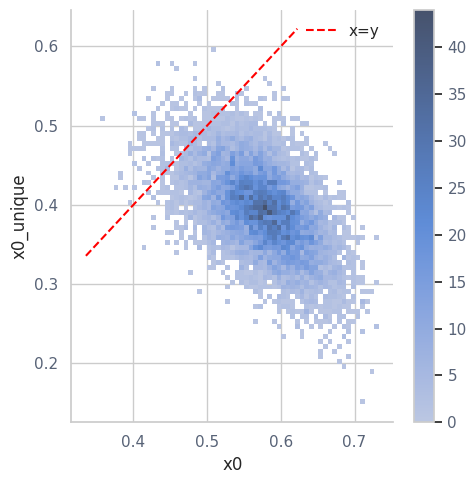

In [17]:
plot = sns.displot(scores, x="x0", y="x0_unique", cbar=True)
# Add a diagonal line (with slope=1) using Matplotlib
for ax in plot.axes.flat:
    x_limits = ax.get_xlim()  # Get actual x-axis limits
    y_limits = ax.get_ylim()  # Get actual y-axis limits

    # Calculate the diagonal line limits based on the actual plot bounds
    diagonal_min = max(x_limits[0], y_limits[0])
    diagonal_max = min(x_limits[1], y_limits[1])

    # Plot the line on the current axis
    ax.plot([diagonal_min, diagonal_max], [diagonal_min, diagonal_max],
            color="red", linestyle="--", linewidth=1.5, label="x=y")
plt.legend()